In [3]:
# Install required libraries (if not already installed)
# pip install pandas numpy scikit-learn matplotlib seaborn nltk

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, silhouette_samples
import nltk
from nltk.corpus import stopwords
from collections import Counter


In [4]:
#  Download NLTK stopwords
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [5]:
#  Load dataset
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='latin-1', header=None)
df.columns = ['target', 'id', 'date', 'flag', 'user', 'text']


In [7]:
#  Sample subset for faster processing
df_sample = df.sample(n=10000, random_state=42).copy()


In [8]:
#  Clean tweet text
def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)     # Remove mentions
    text = re.sub(r"#\w+", "", text)     # Remove hashtags
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters
    text = text.lower()
    words = text.split()
    words = [word for word in words if word not in stopwords.words('english')]
    return " ".join(words)

df_sample['clean_text'] = df_sample['text'].apply(clean_text)


In [9]:
 #TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf.fit_transform(df_sample['clean_text'])


In [10]:
#  Elbow Method to find optimal K
inertia = []
K_range = range(2, 11)
for k in K_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X_tfidf)
    inertia.append(model.inertia_)


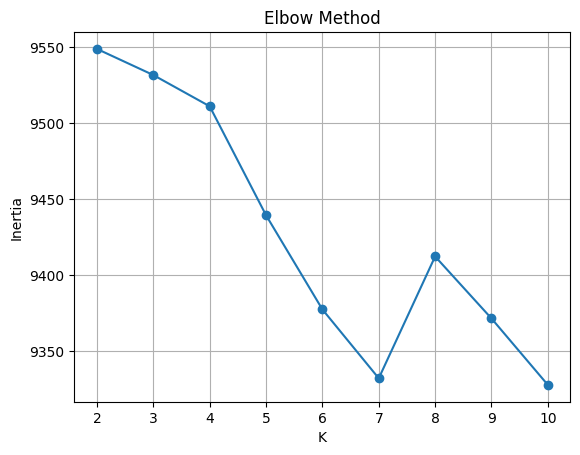

In [11]:
#  Plot Elbow Curve
plt.plot(K_range, inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("K")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()


In [12]:
#  Apply KMeans with chosen K
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
labels = kmeans.fit_predict(X_tfidf)
df_sample['Cluster'] = labels


In [14]:
#  Silhouette Scores per cluster
sil_samples = silhouette_samples(X_tfidf, labels)
df_sample['silhouette'] = sil_samples
print("\nAverage Silhouette Score per Cluster:")
print(df_sample.groupby('Cluster')['silhouette'].mean())



Average Silhouette Score per Cluster:
Cluster
0    0.034398
1    0.009850
2    0.067475
3    0.076000
4    0.032108
Name: silhouette, dtype: float64


In [15]:
#  Top Words in Each Cluster
print("\nTop Words per Cluster:")
for i in range(optimal_k):
    words = ' '.join(df_sample[df_sample['Cluster'] == i]['clean_text']).split()
    top_words = Counter(words).most_common(10)
    print(f"\nCluster {i}: {top_words}")



Top Words per Cluster:

Cluster 0: [('hope', 205), ('tonight', 110), ('good', 37), ('get', 31), ('well', 30), ('day', 29), ('u', 26), ('see', 23), ('better', 23), ('soon', 20)]

Cluster 1: [('good', 485), ('day', 414), ('like', 401), ('get', 401), ('dont', 386), ('go', 365), ('today', 319), ('work', 315), ('got', 312), ('love', 312)]

Cluster 2: [('new', 242), ('get', 19), ('im', 17), ('cant', 16), ('love', 15), ('wait', 14), ('like', 14), ('today', 14), ('album', 13), ('day', 13)]

Cluster 3: [('working', 121), ('im', 18), ('day', 15), ('going', 9), ('today', 8), ('like', 8), ('well', 8), ('new', 8), ('work', 8), ('get', 7)]

Cluster 4: [('im', 1041), ('going', 89), ('get', 68), ('sorry', 65), ('lol', 60), ('good', 54), ('go', 52), ('know', 49), ('still', 48), ('dont', 47)]


In [16]:
 #Compare Clusters with Original Sentiment Labels
print("\nCluster vs Sentiment (0 = Negative, 4 = Positive):")
print(pd.crosstab(df_sample['Cluster'], df_sample['target']))



Cluster vs Sentiment (0 = Negative, 4 = Positive):
target      0     4
Cluster            
0         140   166
1        4125  4245
2          84   149
3          73    47
4         582   389


In [18]:
#  Sample Tweets per Cluster
for i in range(optimal_k):
    print(f"\n Sample Tweets from Cluster {i}:")
    print(df_sample[df_sample['Cluster'] == i]['text'].head(3).to_string(index=False))



 Sample Tweets from Cluster 0:
            @chrishasboobs AHHH I HOPE YOUR OK!!! 
                   Off to Whipsnade  Hope it's dry
Roast in the cooker and cakes in the oven soon....

 Sample Tweets from Cluster 1:
@misstoriblack cool , i have no tweet apps  for...
@TiannaChaos i know  just family drama. its lam...
School email won't open  and I have geography s...

 Sample Tweets from Cluster 2:
@KingdomGuard welcome new cd out this week...ma...
@PaulaAbdul awww, Good luck Paula!! Please don'...
@mileycyrus Green Day new cd on the 15th and yo...

 Sample Tweets from Cluster 3:
Working on photos from Hillsong's 1 year celebr...
tried to check out your site @poeticmindset ......
Working today. Closing. 2 - 11. Missing out on ...

 Sample Tweets from Cluster 4:
@PerezHilton Zach makes me pee sitting down! An...
i'm feeling quite sleepy today, wish i could st...
im turning 18 one week from now  but i don't fe...
